In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)
from vertical_spacing_main import main, draw_bbox_coord
from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)
from left_right_on_block import left_right_margin
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy


## Draw the boxes on document pages

In [16]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [2]:
base_dir   = '/home/naresh/Tesseract/document-structurelocal/data'
#base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'

input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
filename    = 'DELHI_HC_00001.pdf'

In [3]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: DELHI_HC_00001.pdf


In [4]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (21) in file (DELHI_HC_00001.xml)


In [5]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [17]:
file_index=1
img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


# vertical spacings

In [18]:
#dataframe = main(image_files,xml_dfs, page_width, page_height,document_configs)

#####draw bounding boxes
#draw_bbox_coord(image_files, dataframe)

In [8]:
#dataframe

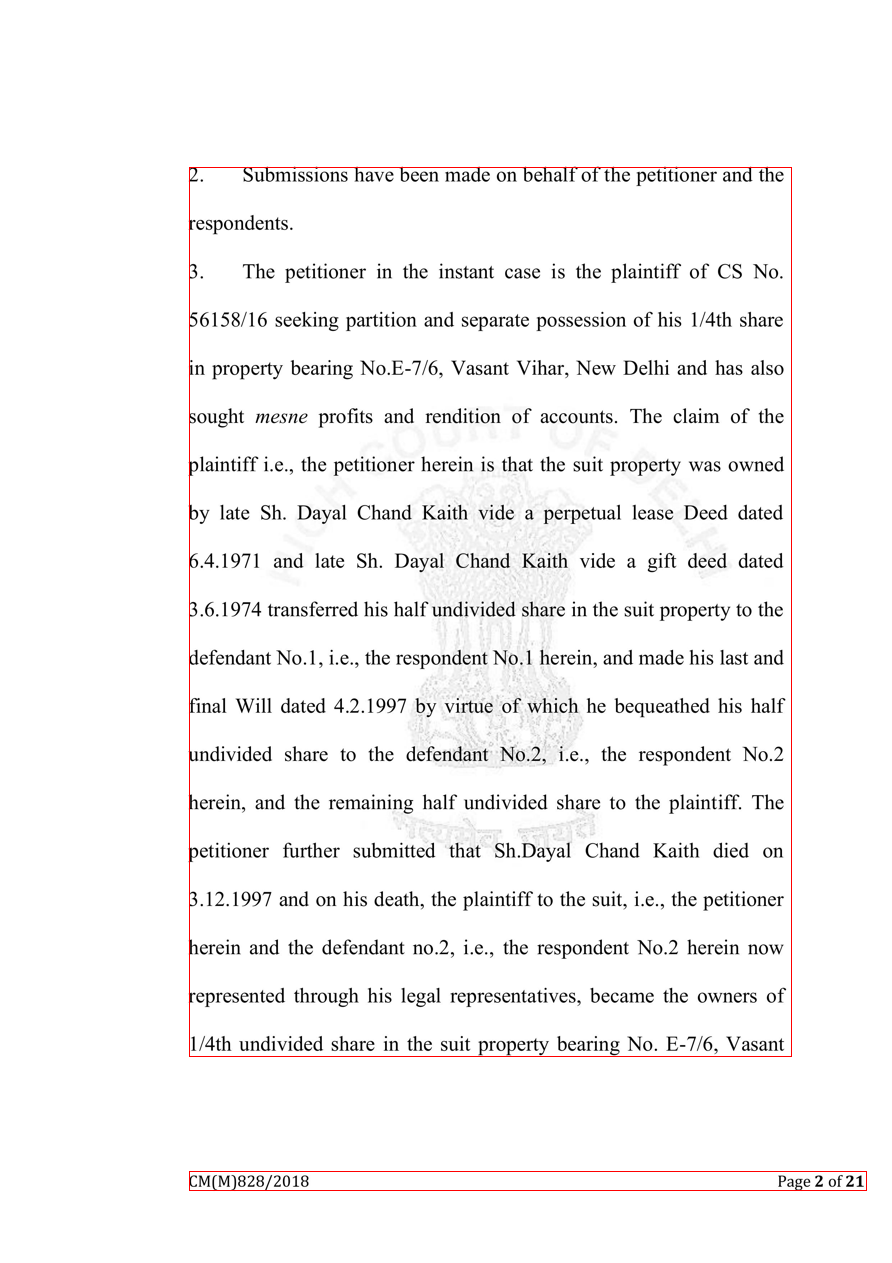

In [26]:
in_df   = df.loc[:]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, v_df, color='red')
# show_df(h_df)


# logic for single block

In [20]:
block_configs = {
    "right_margin_threshold": 0.10,  "left_margin_threshold": 0.10,
    "right_break_threshold": 0.04,   "left_break_threshold": 0.05,
    "header_left_threshold": 0.70,  "header_right_threshold": 0.85,
    "space_multiply_factor": 1.8
}

In [21]:
def process_page_blocks(page_df, configs,block_configs, debug=False):
    cols      = page_df.columns.values.tolist()
    
    df        = pd.DataFrame(columns=cols)
    
    block_index = 0
    for index, row in page_df.iterrows():
        if row['children'] == None:
            df = df.append(page_df.iloc[index])
        else:
            dfs = process_block(page_df.iloc[index], block_configs)
            df = df.append(dfs)
    return df

In [22]:
def process_block(children, block_configs):
    
    dfs = left_right_margin(children, block_configs)
    return dfs

In [23]:
p_df = process_page_blocks(v_df, document_configs,block_configs)
p_df = p_df.reset_index()
p_df = p_df.drop(columns=['level_0','index'])

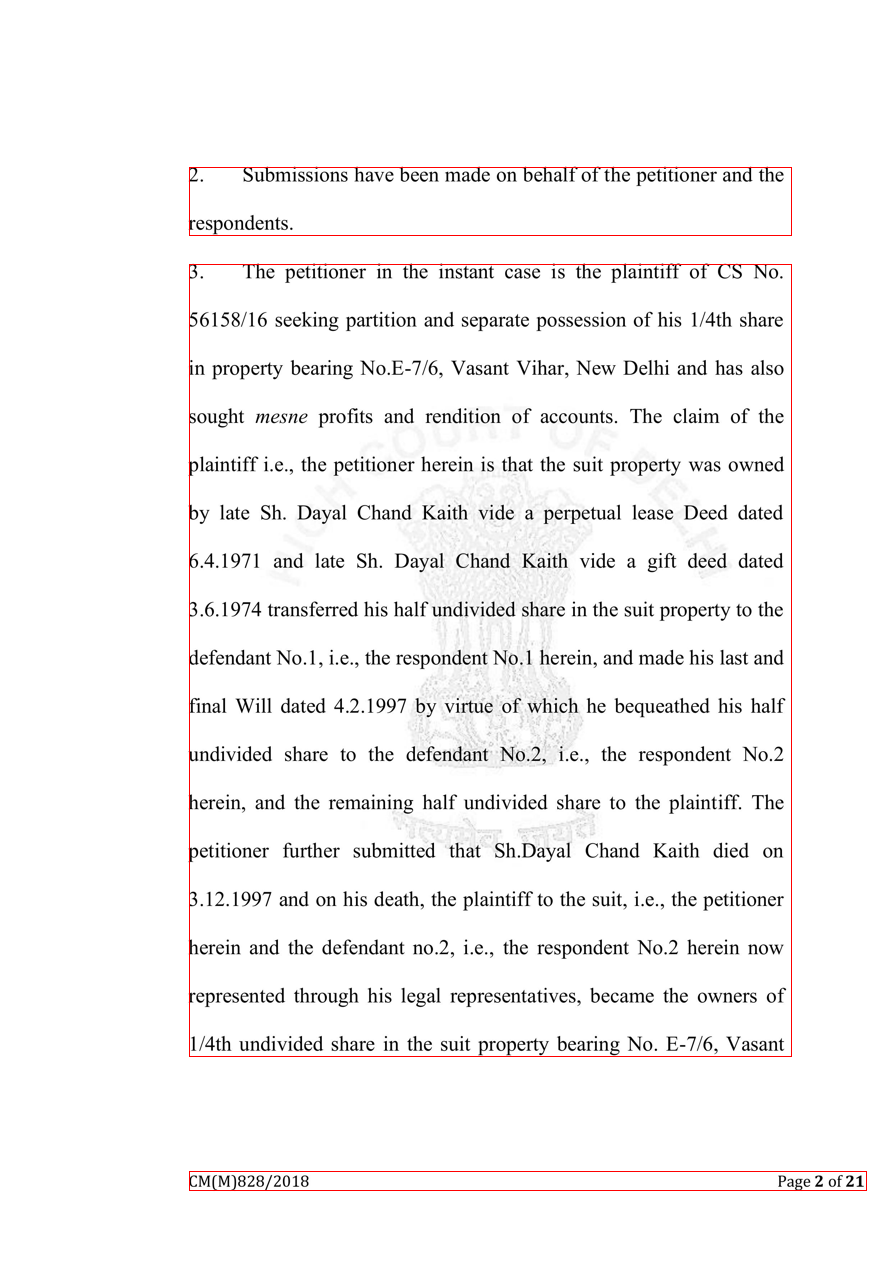

In [24]:
draw_box(img_filepath, page_width, page_height, p_df, color='red')

In [62]:
p_df

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
0,0,54,108,200,37,Civil Appeal No.5808 of 2017 SK. MD. Rafique vs.,16,BAAAAA+LiberationSerif,#a6a6a6,"{""index"":{""0"":0,""1"":1},""xml_index"":{""0"":0,""1"":..."
1,2,92,108,453,18,"Managing Committee, contai Rahamania High Madr...",16,BAAAAA+LiberationSerif,#a6a6a6,NaN
2,3,115,775,10,19,2,16,CAAAAA+DejaVuSans,#000009,None
3,4,179,257,467,71,CONMT.PET.(C) No.1509/2017 in C.A. No.5808/201...,21,BAAAAA+LiberationSerif,#000009,"{""index"":{""0"":4,""1"":5},""xml_index"":{""0"":4,""1"":..."
4,6,275,255,472,265,CONMT.PET.(C) No.1798/2017 in C.A. No.5808/201...,21,BAAAAA+LiberationSerif,#000009,"{""index"":{""2"":6,""3"":7,""4"":8,""5"":9,""6"":10,""7"":1..."
5,12,565,233,516,23,CONMT.PET.(C) No.1921-1922/2018 in C.A. No.580...,21,BAAAAA+LiberationSerif,#000009,NaN
6,13,686,413,156,23,J U D G M E N T,21,DAAAAA+LiberationSerif,#000009,NaN
7,14,734,151,189,23,"Uday Umesh Lalit, J.",21,DAAAAA+LiberationSerif,#000009,NaN
8,15,806,151,634,313,1. These appeals arise out of the ...,21,BAAAAA+LiberationSerif,#000009,"{""index"":{""0"":15,""1"":16,""2"":17,""3"":18,""4"":19,""..."
9,25,1135,108,308,19,The High Court of Judicature at Calcutta 1,18,BAAAAA+LiberationSerif,#000009,None


In [65]:
d1 = pd.read_json(p_df['children'][8])
d1

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
0,15,15,806,151,634,23,1. These appeals arise out of the ...,21,BAAAAA+LiberationSerif,#000009,"{""xml_index"":{""15"":15,""16"":16},""text_top"":{""15..."
1,16,17,854,151,634,24,1 09.12.2015 passed by the Division Bench of t...,21,BAAAAA+LiberationSerif,#000009,"{""xml_index"":{""17"":18,""19"":19,""18"":17},""text_t..."
2,17,20,903,151,634,23,A.S.T. No.192 of 2014 and other connected matt...,21,BAAAAA+LiberationSerif,#000009,None
3,18,21,951,151,634,23,the decision of the Single Judge of the High C...,21,BAAAAA+LiberationSerif,#000009,None
4,19,22,1000,151,633,23,Writ Petition No.20650 (W) of 2013 which in tu...,21,BAAAAA+LiberationSerif,#000009,None
5,20,23,1048,151,633,23,"10, 11 and 12 of the West Bengal Madrasah Serv...",21,BAAAAA+LiberationSerif,#000009,None
6,21,24,1096,151,428,23,"(“the Commission Act”, for short) to be ultra ...",21,BAAAAA+LiberationSerif,#000009,None


In [67]:
d2 = pd.read_json(d1['children'][1])
d2

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
17,18,854,681,6,13,1,12,BAAAAA+LiberationSerif,#000009
19,19,855,687,98,23,dismissing,21,BAAAAA+LiberationSerif,#000009
18,17,855,151,529,23,09.12.2015 passed by the Division Bench of the...,21,BAAAAA+LiberationSerif,#000009
